In [12]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import random


ohlc_df = pd.read_csv('../../data/ETHUSDT-ohlcv.csv')
ohlc_df['LOGRET_1'] = list(ohlc_df.ta.log_return())
ohlc_df['NATR_14'] = ohlc_df.ta.natr()
ohlc_df['SLOPE_1'] = ohlc_df.ta.slope()
bbands = ohlc_df.ta.bbands()
ohlc_df['BBB_5_2.0'] = list(bbands['BBB_5_2.0'])
ohlc_df['BBP_5_2.0'] = list(bbands['BBP_5_2.0'])
ohlc_df['PGO_14'] = list(ohlc_df.ta.pgo())
eri = ohlc_df.ta.eri()
ohlc_df['BEARP_13'] = list(eri['BEARP_13'])
ohlc_df['BULLP_13'] = list(eri['BULLP_13'])
ohlc_df['EFI_13'] = ohlc_df.ta.efi()
adx = ohlc_df.ta.adx()
ohlc_df['DMP_14'] = list(adx['DMP_14'])
ohlc_df['DMN_14'] = list(adx['DMN_14'])
ohlc_df['CG_10'] = ohlc_df.ta.cg()
trix = ohlc_df.ta.trix()
ohlc_df['TRIX_30_9'] = trix['TRIX_30_9']
ohlc_df['TRIXs_30_9'] = trix['TRIXs_30_9']
smi = ohlc_df.ta.smi()
ohlc_df['SMI_5_20_5'] = smi['SMI_5_20_5']
ohlc_df['SMIs_5_20_5'] = smi['SMIs_5_20_5']
ohlc_df['SMIo_5_20_5'] = smi['SMIo_5_20_5']
ohlc_df['AD'] = ohlc_df.ta.ad()
ohlc_df['TRUERANGE_1'] = ohlc_df.ta.true_range()
ohlc_df['PVT'] = ohlc_df.ta.pvt()
ohlc_df['EBSW_40_10'] = ohlc_df.ta.ebsw()
ohlc_df['PVOL'] = ohlc_df.ta.pvol()
thermo = ohlc_df.ta.thermo()
ohlc_df['THERMO_20_2_0.5'] = thermo['THERMO_20_2_0.5']
ohlc_df['THERMOma_20_2_0.5'] = thermo['THERMOma_20_2_0.5']
ohlc_df['CHOP_14_1_100'] = ohlc_df.ta.chop()
ohlc_df['PVI_1'] = ohlc_df.ta.pvi()
ohlc_df['VHF_28'] = ohlc_df.ta.vhf()



df = ohlc_df

ts = list(df['time'])
open = list(df['open'])
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
volume = list(df['volume'])
tot = len(ts)
long_runup_lst = []
long_drawdown_lst = []
short_runup_lst = []
short_drawdown_lst = []
candlestick_frame = 12
pnl_threshold = 3

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        max_high = max(high[idx+1:idx+candlestick_frame])
        min_low = min(low[idx+1:idx+candlestick_frame])
        entry_price = open[idx+1]
        long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
        long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
        short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
        short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
    else:
        long_runup_lst.append(0)
        long_drawdown_lst.append(0)
        short_runup_lst.append(0)
        short_drawdown_lst.append(0)     


long=[]
short=[]
dont_trade=[]
signal = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        if long_runup_lst[idx] >= pnl_threshold:
            signal.append('long')
        elif short_runup_lst[idx] >= pnl_threshold:
            signal.append('short')
        else:
            signal.append('dont_trade')
    else:
        signal.append('dont_trade')

df['signal'] = signal

# long_indices = df[df['signal'].str.contains('long', case=False)].index
# short_indices = df[df['signal'].str.contains('short', case=False)].index
# dont_trade_indices = list(df[df['signal'].str.contains('dont_trade', case=False)].index)
# num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
# random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
# df = df.drop(random_indices)

# df.reset_index(drop=True, inplace=True)

# df = df.drop(columns = ['time', 'open', 'high', 'low', 'close', 'volume'], axis=1)
df = df.drop(columns = ['open', 'high', 'low', 'close', 'volume'], axis=1)
df = df.dropna()


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Target mapping,"dont_trade: 0, long: 1, short: 2"
4,Original data shape,"(20513, 28)"
5,Transformed data shape,"(20513, 28)"
6,Transformed train set shape,"(14359, 28)"
7,Transformed test set shape,"(6154, 28)"
8,Numeric features,27
9,Rows with missing values,0.2%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9061,0.9388,0.9061,0.9002,0.8892,0.5000,0.5479,1.4730
lightgbm,Light Gradient Boosting Machine,0.8983,0.9365,0.8983,0.8906,0.8776,0.4412,0.4984,0.4970
et,Extra Trees Classifier,0.8936,0.9387,0.8936,0.8885,0.8676,0.3862,0.4619,0.8280
rf,Random Forest Classifier,0.8890,0.9189,0.8890,0.8817,0.8601,0.3482,0.4280,1.8140
dt,Decision Tree Classifier,0.8673,0.7456,0.8673,0.8684,0.8678,0.4708,0.4710,0.5730
ridge,Ridge Classifier,0.8665,0.0000,0.8665,0.8142,0.8146,0.1168,0.2025,0.2060
lda,Linear Discriminant Analysis,0.8644,0.7721,0.8644,0.8192,0.8280,0.2156,0.2603,0.1600
ada,Ada Boost Classifier,0.8627,0.7606,0.8627,0.8148,0.8244,0.1895,0.2361,2.0200
dummy,Dummy Classifier,0.8611,0.5000,0.8611,0.7414,0.7968,0.0000,0.0000,0.0830
knn,K Neighbors Classifier,0.8556,0.6698,0.8556,0.7879,0.8088,0.1006,0.1397,0.1780


Transformation Pipeline and Model Successfully Saved


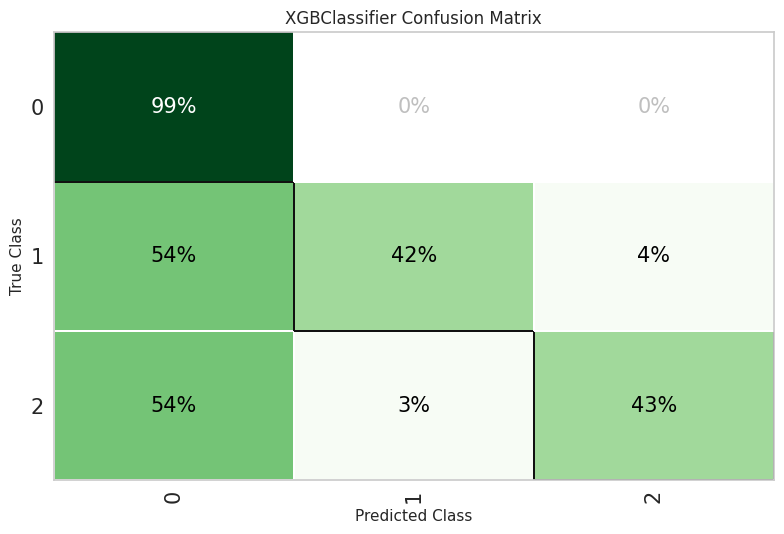

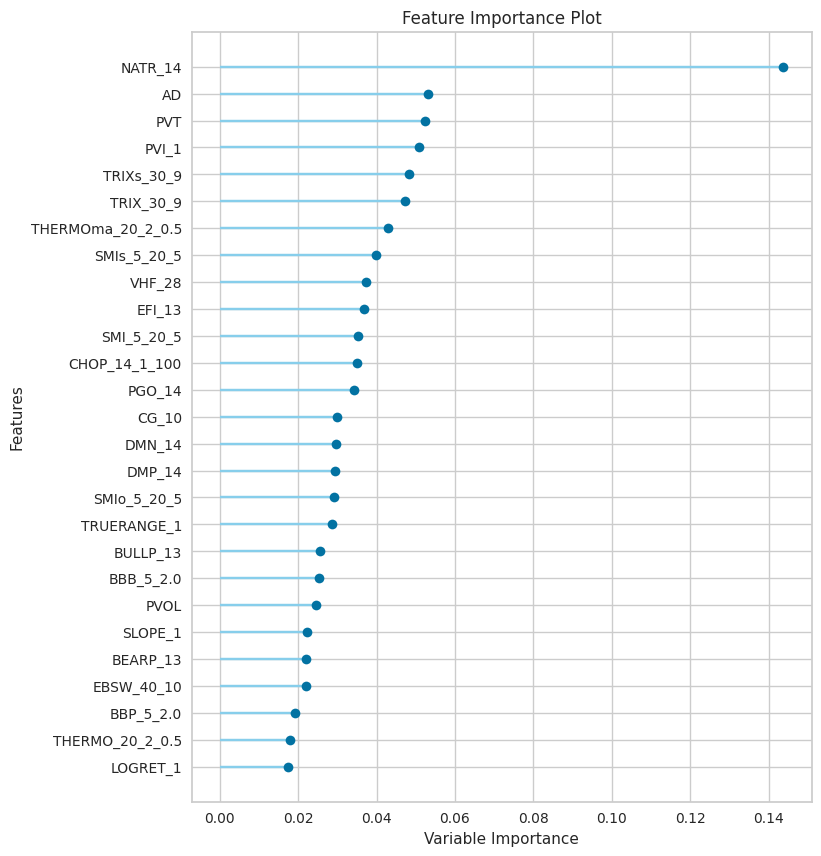

In [2]:

from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd


exp = ClassificationExperiment()
dataset_path = '../../data/'
data = df
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
# model = create_model(LGBMClassifier())
model = compare_models(exclude='gbc')
# validation_scores = pull()
# accuracy_mean = validation_scores['Accuracy']['Mean']

# save pipeline
model_name = 'tsfresh'
save_model(model, f'../../models/{model_name}')
# print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
plot_model(model, plot = 'feature_all')

In [20]:
y = list(df['signal'])

In [22]:
len(y)

20405

In [37]:
candlestick_frame = 12

tot = len(df)
dta_lst = []

columns = list(df.columns)[:-1]
columns.pop(0)
f_str = 'id,time,LOGRET_1,NATR_14,SLOPE_1,BBB_5_2.0,BBP_5_2.0,PGO_14,BEARP_13,BULLP_13,EFI_13,DMP_14,DMN_14,CG_10,TRIX_30_9,TRIXs_30_9,SMI_5_20_5,SMIs_5_20_5,SMIo_5_20_5,AD,TRUERANGE_1,PVT,EBSW_40_10,PVOL,THERMO_20_2_0.5,THERMOma_20_2_0.5,CHOP_14_1_100,PVI_1,VHF_28\n'
time = list(df['time'])
lst_columns = {}
y_tsfresh = []
for c in columns:
    lst_columns[c] = list(df[c])
for id in range(candlestick_frame, tot, 1):
    y_tsfresh.append(y[id])
    app_id = id - candlestick_frame + 1
    for i in range(candlestick_frame):
        app = {}
        app['signal']=y[id]
        app['id'] = app_id
        app['time'] = i
        for c in columns:
            app[c] = lst_columns[c][id-i]
        dta_lst.append(app)

app_df = pd.DataFrame(dta_lst)
training_y = list(app_df['signal'])
app_df = app_df.drop(columns = ['signal'], axis=1)
app_df.to_csv('../../data/df.csv', index=False)
pd.DataFrame({'': y_tsfresh}).to_csv('../../data/y.csv', index=False)
app_df

,id,time,LOGRET_1,NATR_14,SLOPE_1,BBB_5_2.0,BBP_5_2.0,PGO_14,BEARP_13,BULLP_13,...,AD,TRUERANGE_1,PVT,EBSW_40_10,PVOL,THERMO_20_2_0.5,THERMOma_20_2_0.5,CHOP_14_1_100,PVI_1,VHF_28
0,1,0,0.010806,0.875049,19.75,2.894679,0.909110,1.947055,-0.588383,29.041617,...,-1.135733e+05,29.63,-7.364006e+05,0.966555,1.482101e+08,23.61,11.813130,37.314784,995.134603,0.349426
1,1,1,0.001266,0.827213,2.30,1.999747,0.765885,0.799088,4.456887,9.256887,...,-1.610750e+05,4.80,-8.240349e+05,0.973481,4.128125e+07,6.30,10.571354,42.102993,994.048107,0.386687
2,1,2,0.001356,0.871636,2.46,1.697058,0.821647,0.666517,-0.671965,9.038035,...,-1.626836e+05,9.71,-8.269119e+05,0.770668,5.597310e+07,15.19,11.020970,43.704205,994.048107,0.436743
3,1,3,0.009259,0.898760,16.71,1.302934,0.926190,0.498467,-14.878959,4.991041,...,-1.735746e+05,19.87,-8.310953e+05,0.763012,5.045162e+07,11.77,10.582125,44.530639,993.912421,0.437784
4,1,4,-0.001074,0.891810,-1.93,0.709200,0.137337,-0.504174,-15.282119,-6.042119,...,-1.998055e+05,9.24,-8.569817e+05,0.767368,3.860284e+07,4.37,10.457085,37.689944,992.982176,0.523602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244855,20405,7,0.001686,0.124251,2.02,0.358466,0.976381,1.721239,-0.079815,3.400185,...,-1.119099e+07,3.48,-9.863551e+06,0.734477,5.322720e+07,2.64,0.911362,50.656197,969.030348,0.297589
244856,20405,8,0.000334,0.111671,0.40,0.112655,0.928846,0.547024,0.360216,1.160216,...,-1.120987e+07,0.80,-9.871042e+06,0.199615,1.086072e+07,0.78,0.729400,64.001354,968.861590,0.235763
244857,20405,9,0.000368,0.115158,0.44,0.081402,0.919019,0.360236,0.060252,0.510252,...,-1.121032e+07,0.45,-9.871346e+06,-0.615150,5.186235e+06,0.45,0.724074,60.335287,968.828161,0.236436
244858,20405,10,0.000050,0.121168,0.06,0.175563,0.412394,0.165833,-0.304706,0.795294,...,-1.121465e+07,1.10,-9.871505e+06,-0.969104,1.042879e+07,0.38,0.752924,54.703380,968.828161,0.237794


In [38]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
import pandas as pd

df = pd.read_csv('../../data/df.csv')
y = pd.read_csv('../../data/y.csv')

extraction_settings = ComprehensiveFCParameters()

X = extract_features(df, column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction:   0%|          | 0/50 [05:57<?, ?it/s]


KeyboardInterrupt: 